In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import plotly.figure_factory as ff
import geopandas

In [29]:
DF = pd.read_csv('data_cleaned/MERGED_PETER.csv')

DF = DF[~pd.isna(DF['Population'])]
DF = DF[~pd.isna(DF['Area_(sqmi)'])].reset_index(drop=True)
DF.dtypes

Unique_ID                               object
date                                    object
county                                  object
state                                   object
fips                                   float64
cases                                    int64
deaths                                   int64
Latitude                               float64
Longitude                              float64
Total_Hospital_Beds                     object
Total_ICU_Beds                          object
Available_Hospital_Beds                 object
Potentially_Available_Hospital_Beds     object
Available_ICU_Beds                     float64
Potentially_Available_ICU_Beds          object
Adult_Population                        object
Population_65+                          object
Area_(sqmi)                            float64
Population                             float64
dtype: object

In [30]:
for col in DF.columns[5:] :
    DF[col] = DF[col].apply(lambda x : float(str(x).replace(',','')))
DF.dtypes

Unique_ID                               object
date                                    object
county                                  object
state                                   object
fips                                   float64
cases                                  float64
deaths                                 float64
Latitude                               float64
Longitude                              float64
Total_Hospital_Beds                    float64
Total_ICU_Beds                         float64
Available_Hospital_Beds                float64
Potentially_Available_Hospital_Beds    float64
Available_ICU_Beds                     float64
Potentially_Available_ICU_Beds         float64
Adult_Population                       float64
Population_65+                         float64
Area_(sqmi)                            float64
Population                             float64
dtype: object

In [31]:
hospital_ids = np.unique(DF.loc[~pd.isna(DF['Total_Hospital_Beds']),['Unique_ID']].values)

item_seen = []
hospital_locations = []
for i,v in DF.iterrows() :
    if v['Unique_ID'] in hospital_ids :
        if v['Unique_ID'] not in item_seen :
            item_seen.append(v['Unique_ID'])
            hospital_locations.append([v['Latitude'],v['Longitude']])


In [32]:
DF['Pop_Density'] = DF['Population']/DF['Area_(sqmi)']

In [33]:
big_city_ids = set(DF[DF['Pop_Density'] >= 3000]['Unique_ID'])

item_seen = []
big_city_locations = []
for i,v in DF.iterrows() :
    if v['Unique_ID'] in big_city_ids :
        if v['Unique_ID'] not in item_seen :
            item_seen.append(v['Unique_ID'])
            big_city_locations.append([v['Latitude'],v['Longitude']])


In [34]:
def Proximity(location_x,location_y,city_loc,hospital_loc) :
    
    min_distance_city = 1e10
    for loc in city_loc :
        dis = np.sqrt((loc[0] - location_x)**2 + (loc[1] - location_y)**2)
        if dis < min_distance_city :
            min_distance_city = dis
            
    min_distance_hosp = 1e10
    for loc in hospital_loc :
        dis = np.sqrt((loc[0] - location_x)**2 + (loc[1] - location_y)**2)
        if dis < min_distance_hosp :
            min_distance_hosp = dis
            
    return min_distance_city,min_distance_hosp

In [35]:
nearest_big_city,nearest_hospital = [],[]
for i,v in DF.iterrows() :
    if i%500 == 0 :print(i,end=',')
    cit,hos = Proximity(v['Latitude'],v['Longitude'],big_city_locations,hospital_locations)
    nearest_big_city.append(cit)
    nearest_hospital.append(hos)

DF['Nearest_Hospital'] = nearest_hospital
DF['Nearest_BigCity'] = nearest_big_city

0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000,10500,11000,11500,12000,12500,13000,13500,14000,14500,15000,15500,16000,16500,17000,17500,18000,18500,19000,

KeyboardInterrupt: 

In [ ]:
min_date = {uid:sorted(DF[DF['Unique_ID'] == uid]['date'])[0] for uid in DF['Unique_ID'].unique()}

In [ ]:
day_before = []
for date in DF['date'] :
    minus_one = datetime.datetime.strptime(date,'%Y-%M-%d') - datetime.timedelta(days=1)
    day_before.append(datetime.datetime.strftime(minus_one,'%Y-%M-%d'))
    

In [ ]:
DF['day_before_index'] = day_before

In [ ]:
def New_Cases(col) :
    
    new_cases_per_day = []
    
    for i,v in DF.iterrows() :
        
        unique_id = v['Unique_ID']
        date = v['date']
        if date == min_date[unique_id] :
            to_add = v[col]
        else :
            try :
                to_subtract = DF[(DF['Unique_ID'] == unique_id) & (DF['date'] == v['day_before_index'])][col].values[0]
                to_add = v[col] - to_subtract
            except :
                to_add = np.nan
        new_cases_per_day.append(to_add)    
    return new_cases_per_day
        
        
    
DF['New_Cases'] = New_Cases('cases') 
DF['New_Deaths'] = New_Cases('deaths') 

In [21]:
DF.to_csv('data_cleaned/Distance_Calculations.csv',index=False)

In [36]:
## Read in Steve's lagged dataframe

DF = pd.read_csv('output/MASTER_filtered_withlag.csv')

In [27]:
DF['cases_normalized'] = DF['New_Cases']/DF['Population']
DF['day_before_cases_normalized'] = DF['day_before_cases']/DF['Population']

DF['day_before_deaths_normalized'] = DF['day_before_deaths']/DF['Population']

DF = DF[~pd.isna(DF['day_before_cases_normalized'])].reset_index(drop=True)

In [28]:
ind_holdout = []

unique_ids = DF['Unique_ID'].unique()
holdouts = {}

for county in unique_ids :
    
    subbed = DF[DF['Unique_ID'] == county]
    to_hold = sorted(subbed['date'])[-2:]
    holdouts[county] = to_hold

holdout_indices = []
for i,v in DF.iterrows() :
    
    unique_id = v['Unique_ID']
    if v['date'] in holdouts[unique_id] :
        holdout_indices.append(i)
        
    

In [29]:
Holdout_Set = DF.iloc[holdout_indices].reset_index(drop=True)

In [30]:
indices_train = np.setdiff1d(list(DF.index),holdout_indices)

Training_Set = DF.iloc[indices_train].reset_index(drop=True)

In [31]:
cols_drop = ['date','county','state','fips','Latitude','Longitude','Total_Hospital_Beds', 'Total_ICU_Beds',
       'Available_Hospital_Beds', 'Potentially_Available_Hospital_Beds',
       'Available_ICU_Beds', 'Potentially_Available_ICU_Beds',
       'Adult_Population', 'Population_65.','Area_.sqmi.','day_before_index','cases','deaths',
            'day_before_cases', 'day_before_deaths','cases','cases_normalized','New_Deaths']

Holdout_Set_X,Holdout_Set_Y = Holdout_Set.drop(cols_drop,axis=1),Holdout_Set['cases_normalized']
Training_Set_X,Training_Set_Y = Training_Set.drop(cols_drop,axis=1),Training_Set['cases_normalized']

In [136]:
for col in Holdout_Set_X.columns[1:] :
    print(col,np.sum(np.isnan(Holdout_Set[col])))

Population 0
Pop_Density 0
Nearest_Hospital 0
Nearest_BigCity 0
New_Cases 2025
New_Deaths 2025
day_before_cases_normalized 0
day_before_deaths_normalized 0


In [41]:
Training_Set.head()

,Unique_ID,date,county,state,fips,cases,deaths,Latitude,Longitude,Total_Hospital_Beds,...,Nearest_Hospital,Nearest_BigCity,day_before_index,New_Cases,New_Deaths,day_before_cases,day_before_deaths,cases_normalized,day_before_cases_normalized,day_before_deaths_normalized
0,Snohomish_Washington,2020-01-22,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,...,1.866215,10.319262,2020-01-21,0.0,0.0,1.0,0.0,0.0,1.216422e-06,0.0
1,Snohomish_Washington,2020-01-23,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,...,1.866215,10.319262,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2,Snohomish_Washington,2020-01-24,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,...,1.866215,10.319262,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0
3,Cook_Illinois,2020-01-25,Cook,Illinois,17031.0,1,0,41.841448,-87.816588,NaN,...,1.173137,0.000000,2020-01-24,0.0,0.0,1.0,0.0,0.0,1.941660e-07,0.0
4,Snohomish_Washington,2020-01-25,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,...,1.866215,10.319262,2020-01-24,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0


In [32]:

Holdout_Set_X.to_csv('output/Holdout_Set_X.csv',index=False)
Holdout_Set_Y.to_csv('output/Holdout_Set_Y.csv',index=False)
Training_Set_X.to_csv('output/Training_Set_X.csv',index=False)
Training_Set_Y.to_csv('output/Training_Set_Y.csv',index=False)

# Now actually Model the Data

In [2]:
Holdout_Set_X = pd.read_csv('output/Holdout_Set_X.csv',index_col=0)
Holdout_Set_Y = pd.read_csv('output/Holdout_Set_Y.csv',index_col=0)
Training_Set_X = pd.read_csv('output/Training_Set_X.csv',index_col=0)
Training_Set_Y = pd.read_csv('output/Training_Set_Y.csv',index_col=0)

In [3]:
Holdout_Set_X.drop(['New_Cases','New_Deaths','Population'],axis=1,inplace=True)
Training_Set_X.drop(['New_Cases','New_Deaths','Population'],axis=1,inplace=True)

In [4]:
Training_keep = [i for i,v in Training_Set_Y.iterrows() if not np.isnan(v['cases_normalized'])]
Holdout_keep = [i for i,v in Holdout_Set_Y.iterrows() if not np.isnan(v['cases_normalized'])]


Holdout_Set_X = Holdout_Set_X.iloc[Holdout_keep].reset_index(drop=True)
Holdout_Set_Y = Holdout_Set_Y.iloc[Holdout_keep].reset_index(drop=True)
Training_Set_X = Training_Set_X.iloc[Training_keep].reset_index(drop=True)
Training_Set_Y = Training_Set_Y.iloc[Training_keep].reset_index(drop=True)

In [256]:
def Normalize_Data(Train_X,Test_X) :
    
    min_vals = {}
    max_vals = {}
    
    for col in Train_X.columns :
        if Train_X[col].dtype.name == 'object' :
            continue
        min_vals[col] = min(Train_X[col])
        max_vals[col] = max(Train_X[col])
        
        Train_X[col] = (Train_X[col] - min_vals[col])/(max_vals[col] - min_vals[col])
        Test_X[col] = (Test_X[col] - - min_vals[col])/(max_vals[col] - min_vals[col])
        
    return Train_X,Test_X,min_vals,max_vals

In [257]:
rand_inds = np.random.permutation(Training_Set_X.index)

percent_training=.7

trainings_ind = rand_inds[:int(percent_training*len(rand_inds))]
val_ind = rand_inds[int(percent_training*len(rand_inds)):]

In [258]:
train_x,train_y = Training_Set_X.iloc[trainings_ind].reset_index(drop=True),Training_Set_Y.iloc[trainings_ind].reset_index(drop=True)
val_x,val_y = Training_Set_X.iloc[val_ind].reset_index(drop=True),Training_Set_Y.iloc[val_ind].reset_index(drop=True)

In [259]:
train_x_normalized,val_x_normalized,min_values,max_values = Normalize_Data(train_x,val_x)

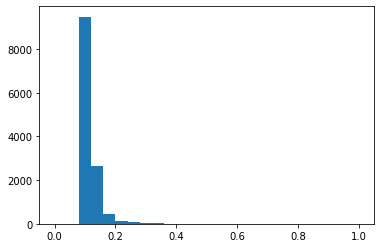

In [260]:
plt.hist(train_x[train_x.columns[4]],bins=25)
plt.show()

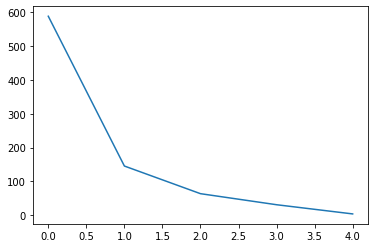

In [261]:
Cov_Mat = np.array(train_x_normalized.drop('Unique_ID',axis=1)).T.dot(np.array(train_x_normalized.drop('Unique_ID',axis=1)))

U,S,V = np.linalg.svd(Cov_Mat)

percent_var = 0
counter = 0
while percent_var < .95 :
    percent_var = np.sum(S[:counter])/np.sum(S)
    counter += 1

plt.plot(range(len(S)),S)

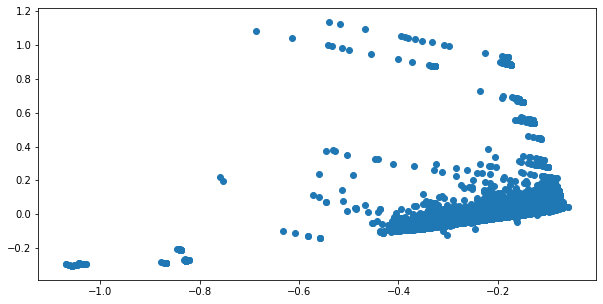

In [262]:
plot_PCA = np.array(train_x_normalized.drop('Unique_ID',axis=1)).dot(U[:,:2])

plt.figure(figsize=(10,5))
plt.scatter(plot_PCA[:,0],plot_PCA[:,1])

In [263]:
Training_Set_X.head()

,Unique_ID,Pop_Density,Nearest_Hospital,Nearest_BigCity,day_before_cases_normalized,day_before_deaths_normalized
0,Snohomish_Washington,393.341148,1.866215,10.319262,1.216422e-06,0.0
1,Snohomish_Washington,393.341148,1.866215,10.319262,0.000000e+00,0.0
2,Snohomish_Washington,393.341148,1.866215,10.319262,0.000000e+00,0.0
3,Cook_Illinois,5444.220930,1.173137,0.000000,1.941660e-07,0.0
4,Snohomish_Washington,393.341148,1.866215,10.319262,0.000000e+00,0.0


In [268]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge,Lasso

In [274]:
def Cross_Validation(Train_X,Train_Y,a_val,nruns=10) :
    
    for run in range(nruns) :
        rand_inds = np.random.permutation(Train_X.index)

        percent_training=.7

        trainings_ind = rand_inds[:int(percent_training*len(rand_inds))]
        val_ind = rand_inds[int(percent_training*len(rand_inds)):]
        
        train_x,train_y = Train_X.iloc[trainings_ind].reset_index(drop=True),Train_Y.iloc[trainings_ind].reset_index(drop=True)
        val_x,val_y = Train_X.iloc[val_ind].reset_index(drop=True),Train_Y.iloc[val_ind].reset_index(drop=True)
        
        train_x_normalized,val_x_normalized,min_values,max_values = Normalize_Data(train_x,val_x)
        
        mod = Ridge(alpha=a_val)
        mod.fit(train_x_normalized.drop('Unique_ID',axis=1),train_y['cases_normalized'])

        train_pred = mod.predict(train_x_normalized.drop('Unique_ID',axis=1))
        print('Training',mod.score(train_x_normalized.drop('Unique_ID',axis=1),train_y['cases_normalized']))
        
        print('Testing',mod.score(val_x_normalized.drop('Unique_ID',axis=1),val_y['cases_normalized']))

In [276]:
for alpha in [.0001,.001,.01,.1,1,10] :
    Cross_Validation(Training_Set_X,Training_Set_Y,alpha,10)

Training 0.3422404755456123
Testing -17.75464808873116
Training 0.38915575017215775
Testing -27.017958243929225
Training 0.3849027531155338
Testing -164.13798101279286
Training 0.35196744215523834
Testing -151.56768578699996
Training 0.3815200800757107
Testing -176.67196515515704
Training 0.39643083393120937
Testing -125.6240860510956
Training 0.38157580336430824
Testing -30.415718800540194
Training 0.3687118405270131
Testing -152.50449137908754
Training 0.33567846907558163
Testing -8.066160762154379
Training 0.3903954298527632
Testing -31.675137047454978
Training 0.35834493160134495
Testing -201.60507081028143
Training 0.4040484006473068
Testing -24.642597154487962
Training 0.37806000529104833
Testing -24.462948932602888
Training 0.3610463197344581
Testing -142.0715396258215
Training 0.3788633514176749
Testing -27.39610781969157
Training 0.39956515133239
Testing -21.722178485254226
Training 0.4050893386823876
Testing -209.73447932223755
Training 0.39735552457464485
Testing -18.0957234

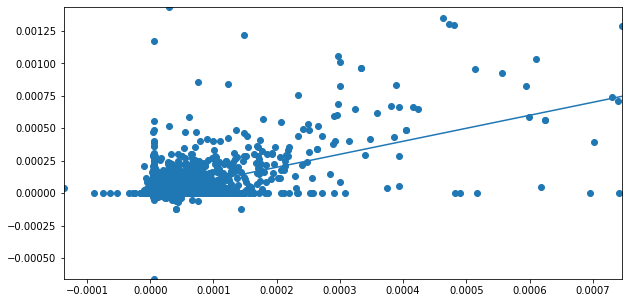

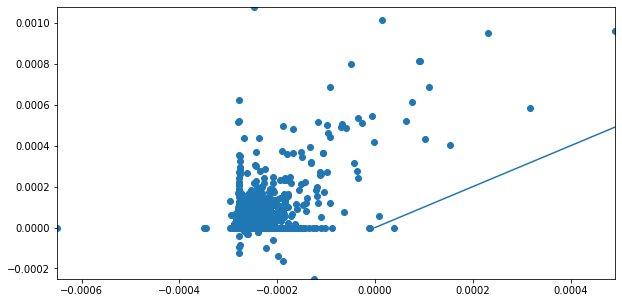

In [273]:
rand_inds = np.random.permutation(Training_Set_X.index)

percent_training=.7

trainings_ind = rand_inds[:int(percent_training*len(rand_inds))]
val_ind = rand_inds[int(percent_training*len(rand_inds)):]

train_x,train_y = Training_Set_X.iloc[trainings_ind].reset_index(drop=True),Training_Set_Y.iloc[trainings_ind].reset_index(drop=True)
val_x,val_y = Training_Set_X.iloc[val_ind].reset_index(drop=True),Training_Set_Y.iloc[val_ind].reset_index(drop=True)

train_x_normalized,val_x_normalized,min_values,max_values = Normalize_Data(train_x,val_x)

mod = Ridge()
mod.fit(train_x_normalized.drop('Unique_ID',axis=1),train_y['cases_normalized'])

train_pred = mod.predict(train_x_normalized.drop('Unique_ID',axis=1))
test_pred = mod.predict(val_x_normalized.drop('Unique_ID',axis=1))

plt.figure(figsize=(10,5))
plt.scatter(train_pred,train_y)
plt.xlim(min(train_pred),max(train_pred))
plt.ylim(min(train_y['cases_normalized']),max(train_y['cases_normalized']))
plt.plot([0,1],[0,1])
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(test_pred,val_y)
plt.xlim(min(test_pred),max(test_pred))
plt.ylim(min(val_y['cases_normalized']),max(val_y['cases_normalized']))
plt.plot([0,1],[0,1])
plt.show()

In [252]:
max_values

{'Population': 10039107,
 'Pop_Density': 19675.4797520508,
 'Nearest_Hospital': 33.7457093934821,
 'Nearest_BigCity': 40.34373992148621,
 'day_before_cases_normalized': 0.0013474979204331635,
 'day_before_deaths_normalized': 0.00047348484848484855}

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        4.000e+00, 2.000e+00, 1.100e+01, 8.697e+03, 2.992e+03, 5.870e+02,
        2.400e+02, 1.100e+02, 4.500e+01, 4.000e+01, 3.200e+01, 1.100e+01,
        1.400e+01, 9.000e+00, 9.000e+00, 9.000e+00, 8.000e+00, 7.000e+00,
        4.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 6.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([-6.58327847e-04, -6.16491815e-04, -5.74655782e-04, -5.32819749e-04,
        -4.90983717e-04, -4.49147684e-04, -4.07311651e-04, -3.65475619e-04,
        -3.23639586e-04, -2.81803553e-04, -2.39967521e-04, -1.98131488e-04,
        -1.56295456e-04, -1.14459423e-04, -7.26233903e-05, -3.07873576e-05,
         1.10486750e-05,  5.28847076e-05,  9.47207403e-05,  1.36556773e-

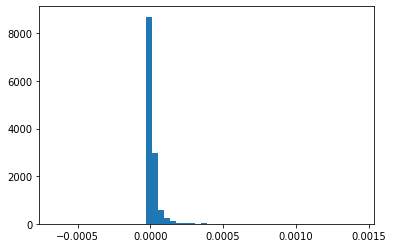

In [221]:
plt.hist(train_y['cases_normalized'],bins=50)

In [278]:
Training_Set_X.head()

,Unique_ID,Pop_Density,Nearest_Hospital,Nearest_BigCity,day_before_cases_normalized,day_before_deaths_normalized
0,Snohomish_Washington,393.341148,1.866215,10.319262,1.216422e-06,0.0
1,Snohomish_Washington,393.341148,1.866215,10.319262,0.000000e+00,0.0
2,Snohomish_Washington,393.341148,1.866215,10.319262,0.000000e+00,0.0
3,Cook_Illinois,5444.220930,1.173137,0.000000,1.941660e-07,0.0
4,Snohomish_Washington,393.341148,1.866215,10.319262,0.000000e+00,0.0


In [12]:
DF = pd.read_csv('results/risk_profile.validation.csv')

In [13]:
FIPS_IDs = pd.read_csv('data/US_County_Level.modified.csv')

In [14]:
FIPS_IDs = FIPS_IDs[~FIPS_IDs['fips'].isnull()]

In [15]:
FIPS_IDs['Unique_ID'] = FIPS_IDs['county'] + "_" + FIPS_IDs['state']

In [16]:
fips_unique = set()
for i,v in FIPS_IDs.iterrows() :
    
    id_add = str(v['Unique_ID']) + '_' + str(int(v['fips']))
    fips_unique.add(id_add)
fips_unique = list(fips_unique)

In [17]:
to_fill = np.zeros((len(fips_unique),2),dtype='object')

for i,v in enumerate(fips_unique) :
    one,two,three = v.split('_')
    to_fill[i][0] = '_'.join([one,two])
    to_fill[i][1] = three.strip()

In [20]:
fips_add = []

for i,v in DF.iterrows() :
    if v['City_State'] in to_fill[:,0] :
        fips_add.append(to_fill[np.where(to_fill[:,0]==v['City_State'])[0][0]][1])
    else :
        fips_add.append(np.nan)
DF['FIPS'] = fips_add
DF.loc[DF['City_State'] == 'NYC_New York','FIPS'] = '36061' 
DF['FIPS'] = DF['FIPS'].apply(lambda x : int(str(x).zfill(5)))

In [26]:
fips = DF['FIPS'].to_list()
values = DF['risk_rank'].to_list()

colorscale = ["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
              "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
              "#08519c","#0b4083","#08306b"]

endpts = list(np.linspace(0, 1, len(colorscale) - 1))

fig = ff.create_choropleth(
    fips=fips, values=values,
    binning_endpoints=endpts,
    colorscale=colorscale,
    show_state_data=False,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=2.9, title='Risk Ranking Profile'
)

fig.layout.template = None
fig.show()